<a href="https://colab.research.google.com/github/Gecrz/DGMD-S-14-Final-Project/blob/main/Breast%20Cancer%20detection%20using%20Computer%20Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT REQUIRED LIBRARIES

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from functools import partial
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

import os
import pandas as pd
import numpy as np

import requests
from tqdm import tqdm

import tarfile
import os
import shutil
import io

# DATA INGESTION

For our project, we'll be focusing specifically on PNG images with a magnification level of 400x within our dataset. These high-resolution images will provide superior detail, enhancing our ability to effectively identify patterns.

Contrarily, images at lower magnification levels might potentially limit our pattern detection capability due to their reduced detail. Hence, we need to segregate all the 400x magnification PNG files into a dedicated folder, discarding the lower magnification ones.

Note: Our work is primarily concentrated on images with a 400x magnification level.

In [ ]:
#download the data using the below code into your local setup
url = 'http://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz'
file_path = 'BreaKHis_v1.tar.gz'

response = requests.get(url, stream=True)

if response.status_code == 200:


  total_size = int(response.headers.get('content-length', 0))
  progress_bar = tqdm(total=total_size, unit='B', unit_scale=True)

  with open(file_path, 'wb') as file:
      for chunk in response.iter_content(chunk_size=1024):
          if chunk:
              file.write(chunk)
              progress_bar.update(len(chunk))

  progress_bar.close()
  print('File downloaded successfully.')
else:

  print('Failed to download the file.')


100%|██████████| 4.27G/4.27G [05:33<00:00, 12.8MB/s]

File downloaded successfully.


In [ ]:
# get all the 400x png files into a folder

# Define the tar file
tar_file_path = 'BreaKHis_v1.tar.gz'

# Define the directory to store the extracted files
output_dir = 'extracted_images_400x'
os.makedirs(output_dir, exist_ok=True)

# Open the tar file
tar = tarfile.open(tar_file_path)

# Iterate over each member in the tar file
for member in tar.getmembers():
    if '400X' in member.name and member.name.endswith('.png'):
        # Use extractfile() to get a file-like object for the file data
        file_data = tar.extractfile(member)

        if file_data is not None:
            # Get the base filename (without directories)
            base_filename = os.path.basename(member.name)
            # Define the target file path in the output_dir
            target_path = os.path.join(output_dir, base_filename)

            # Write the file data to the new file
            with open(target_path, 'wb') as f:
                shutil.copyfileobj(file_data, f)

# Close the tar file
tar.close()


In [ ]:
!ls extracted_images_400x | head -n 20


SOB_B_A-14-22549AB-400-001.png
SOB_B_A-14-22549AB-400-002.png
SOB_B_A-14-22549AB-400-003.png
SOB_B_A-14-22549AB-400-004.png
SOB_B_A-14-22549AB-400-005.png
SOB_B_A-14-22549AB-400-006.png
SOB_B_A-14-22549AB-400-007.png
SOB_B_A-14-22549AB-400-008.png
SOB_B_A-14-22549AB-400-009.png
SOB_B_A-14-22549AB-400-010.png
SOB_B_A-14-22549AB-400-011.png
SOB_B_A-14-22549AB-400-012.png
SOB_B_A-14-22549AB-400-013.png
SOB_B_A-14-22549AB-400-014.png
SOB_B_A-14-22549AB-400-015.png
SOB_B_A-14-22549AB-400-016.png
SOB_B_A-14-22549AB-400-017.png
SOB_B_A-14-22549AB-400-018.png
SOB_B_A-14-22549AB-400-019.png
SOB_B_A-14-22549AB-400-020.png


# DATA PREP AND VISUALIZATION

### Constructing a Focused DataFrame

---

The original dataset differentiates between various subcategories of both malignant and benign types of cancer. However, in alignment with our project's key objective, we'll be simplifying our approach. Rather than diving into these subcategories, our focus will be binary - distinguishing whether a cancer case is malignant or benign.

The ensuing code generates a DataFrame that encompasses the following crucial information:

1. **Image Path:** This refers to the path where the image file is located - an essential asset for our model training.
2. **Cancer Type:** Identified as 'M' for malignant and 'B' for benign, this information distinguishes the type of cancer.
3. **Patient ID:** A unique identification number attributed to each patient.

At the end of the code execution, you'll observe this DataFrame printed out.


In [ ]:
#creating a dataframe that has the patient id, file path, type

# Define the directory where the files are stored
directory = 'extracted_images_400x'

# Get the list of file names
filenames = os.listdir(directory)

# Create a DataFrame from the file names
df = pd.DataFrame(filenames, columns=['filename'])

# Extract the type (M or B), patient ID and image ID from the filename
df['type'] = df['filename'].str.split('_', expand=True)[1]
df['patient_ID'] = df['filename'].str.split('-', expand=True)[2]

# Display the DataFrame
df


,filename,type,patient_ID
0,SOB_B_F-14-25197-400-052.png,B,25197
1,SOB_M_PC-14-9146-400-009.png,M,9146
2,SOB_M_DC-14-2773-400-020.png,M,2773
3,SOB_B_TA-14-3411F-400-001.png,B,3411F
4,SOB_B_PT-14-21998AB-400-047.png,B,21998AB
...,...,...,...
1815,SOB_M_DC-14-3909-400-010.png,M,3909
1816,SOB_M_DC-14-11520-400-011.png,M,11520
1817,SOB_B_F-14-9133-400-014.png,B,9133
1818,SOB_M_DC-14-5694-400-008.png,M,5694


### Data Splitting: Training, Validation, and Test Sets

We are dividing our dataset based on the unique Patient ID into the following subsets:

- **Training Data:** 80%
- **Validation Data:** 10%
- **Test Data:** 10%

This split is intentionally designed around the Patient ID to replicate the real-world conditions the model will encounter. In practical usage, the model will be deployed on entirely new patients.

For instance, if the model is trained on data from 100 patients, the 101st patient will be completely new to the model. Therefore, to emulate this situation, we have to train our model in a similar fashion - maintaining a portion of the patient data as unseen.

This approach ensures that our model can generalize well to new, unseen patients, thus enhancing its predictive accuracy in real-world applications.


In [ ]:

# Get a list of unique patient IDs for each type
malignant_ids = df[df['type'] == 'M']['patient_ID'].unique()
benign_ids = df[df['type'] == 'B']['patient_ID'].unique()

# Function to split patient IDs into train, validation, and test
def split_ids(ids):
    np.random.shuffle(ids)
    train_size = int(len(ids) * 0.8)
    val_size = int(len(ids) * 0.1)
    train_ids = ids[:train_size]
    val_ids = ids[train_size:train_size + val_size]
    test_ids = ids[train_size + val_size:]
    return train_ids, val_ids, test_ids

# Split patient IDs for each type
train_m_ids, val_m_ids, test_m_ids = split_ids(malignant_ids)
train_b_ids, val_b_ids, test_b_ids = split_ids(benign_ids)

# Concatenate train, validation, and test patient IDs
train_patient_ids = np.concatenate([train_m_ids, train_b_ids])
val_patient_ids = np.concatenate([val_m_ids, val_b_ids])
test_patient_ids = np.concatenate([test_m_ids, test_b_ids])

# Get corresponding dataframes
train_df = df[df['patient_ID'].isin(train_patient_ids)]
val_df = df[df['patient_ID'].isin(val_patient_ids)]
test_df = df[df['patient_ID'].isin(test_patient_ids)]


Checking the number of patients that ended up in each training, validation and test sets.

In [ ]:
print('file name is', 'train_df')
for column in train_df.columns:
    print(column, train_df[column].nunique())


print('file name is', 'val_df')
for column in val_df.columns:
    print(column, val_df[column].nunique())


print('file name is', 'test_df')
for column in test_df.columns:
    print(column, test_df[column].nunique())


file name is train_df
filename 1383
type 2
patient_ID 64
file name is val_df
filename 153
type 2
patient_ID 7
file name is test_df
filename 284
type 2
patient_ID 10


### Sample Images

The M stands for Malignant and the B stands for Benign, the code below shows some sample images from both the Benign class and the Malignant class.

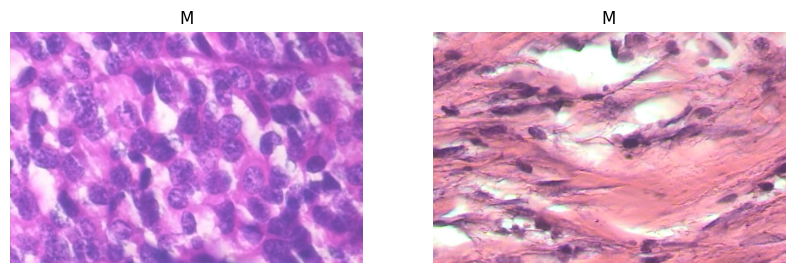

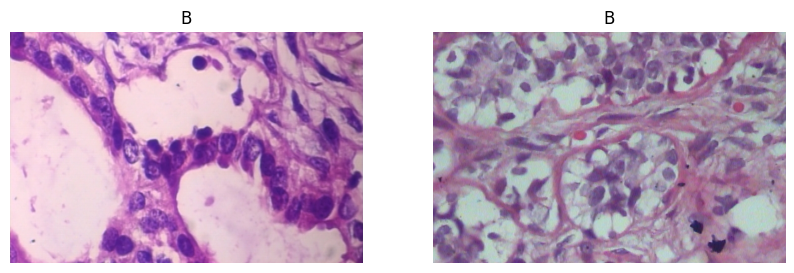

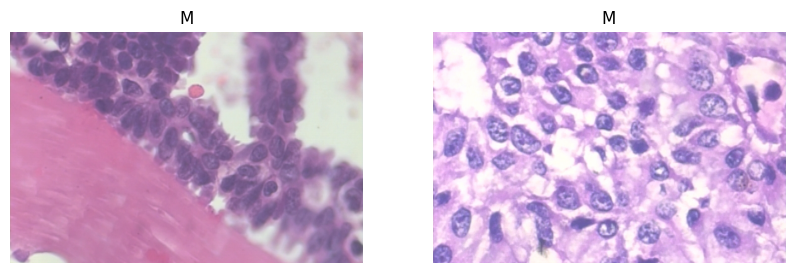

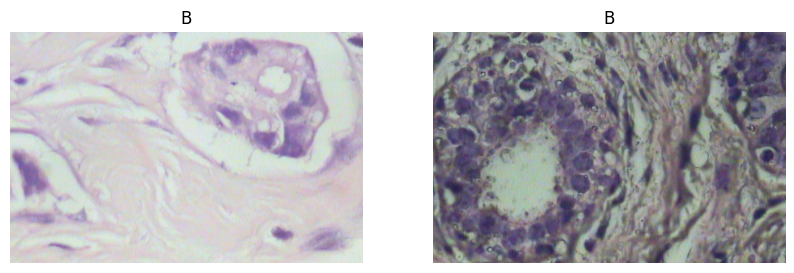

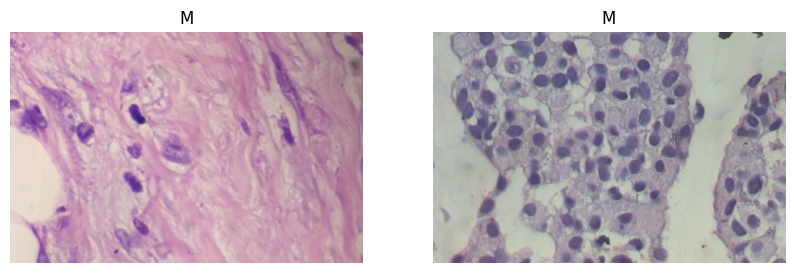

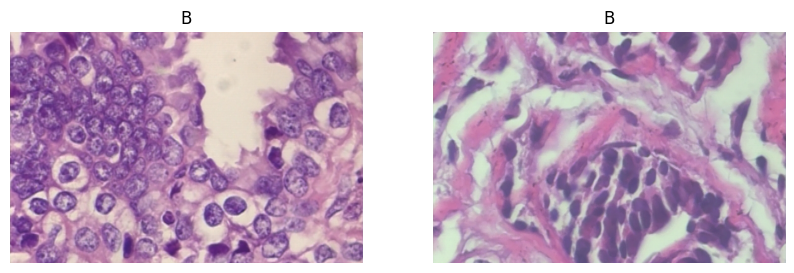

In [ ]:
# Function to plot a couple of sample images
def plot_sample_images(df, directory, class_name, num_samples=2):
    plt.figure(figsize=(10, 4))
    for i in range(num_samples):
        filename = df[df['type'] == class_name]['filename'].iloc[i]
        img_path = os.path.join(directory, filename)
        img = plt.imread(img_path)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()


# Plot a couple of sample images from the train set
plot_sample_images(train_df, directory, 'M', num_samples=2)
plot_sample_images(train_df, directory, 'B', num_samples=2)

# Plot a couple of sample images from the validation set
plot_sample_images(val_df, directory, 'M', num_samples=2)
plot_sample_images(val_df, directory, 'B', num_samples=2)

# Plot a couple of sample images from the test set
plot_sample_images(test_df, directory, 'M', num_samples=2)
plot_sample_images(test_df, directory, 'B', num_samples=2)


### Class imbalance Visualized

There is class imbalance in the data, our classification report will show that our model still performs very well. However, we would like to address this in future models we build.

In [ ]:
# Function to plot class distribution
def plot_class_distribution(y_true, class_names):
    class_counts = y_true.value_counts()
    plt.bar(class_names, class_counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()


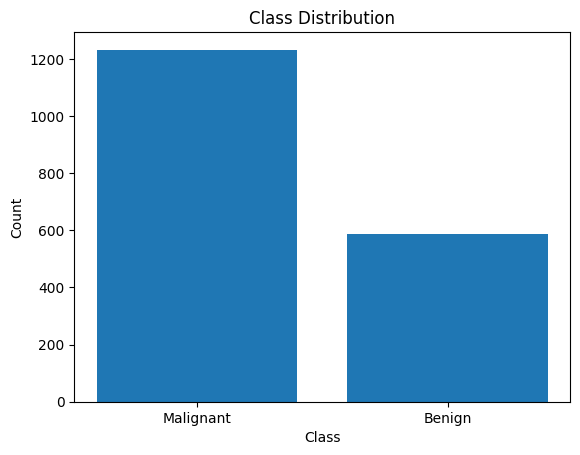

In [ ]:
# Define the class names based on your dataset
class_names = ['Malignant', 'Benign']

# Plot the class distribution for the entire dataset (train + validation + test)
combined_df = pd.concat([train_df, val_df, test_df])
plot_class_distribution(combined_df['type'].map({'B': 0, 'M': 1}), class_names)


This code is used for image preprocessing and data augmentation, which are essential steps in deep learning models for image classification.

- It first sets the image size, batch size, and directory of the images.

Next, it uses `ImageDataGenerator` for:

- Training data: Rescales the pixel values from [0, 255] to [0, 1], rotates the images randomly within -10 to +10 degrees, and applies random horizontal and vertical shifts to augment the data.
- Validation data: Only rescales the pixel values (no data augmentation is applied).

Then, it creates two generators (for training and validation data) that:

- Take dataframes containing the image file names and their corresponding classes as input.
- Resize all the images to the defined image size.
- Read the images from the defined directory.
- Convert the class labels into binary format for binary classification tasks.
- Group the images into batches for efficient training.



In [ ]:
# Define image size and path
img_size = (700, 460)
batch_size = 32
directory = 'extracted_images_400x'

# Rescale the pixel values of the images and rotate the images by an angle between -10 to +10 degrees
# Create an image data generator for training data
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, width_shift_range=0.1, height_shift_range=0.1)
# Create an image data generator for validation data
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=directory,
    x_col='filename',
    y_col='type',
    target_size=img_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True,  # Shuffle the training data
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=directory,
    x_col='filename',
    y_col='type',
    target_size=img_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle the validation data
)


Found 1383 validated image filenames belonging to 2 classes.
Found 153 validated image filenames belonging to 2 classes.


# MODEL TRAINING

The model structure is as follows:

- It starts with a 2D convolution layer (Conv2D) with filter size increasing by a factor of 2 at each layer.
- After each Conv2D layer, it adds a Batch Normalization layer to standardize the inputs, helping to improve training speed and model performance.
- It includes Dropout layers after certain Conv2D layers and Dense layers. These randomly "drop out" (set to zero) a number of output features of the layer during training, which helps prevent overfitting.
- It uses a Flatten layer to flatten the 2D outputs from the preceding Conv2D layer into 1D.
Then it uses a Dense layer with 512 nodes.
- It finishes with a Dense layer with one node (the output layer), using a sigmoid activation function for binary classification.

The dropout_rate parameter controls the percentage of nodes that get dropped out during training in the Dropout layers, providing a simple way to control overfitting.

The model is designed to take an image as input and output a single value between 0 and 1, indicating the probability that the image belongs to one of the two classes.

In [ ]:
# Define the standard CNN model
n_filters = 12  # Base number of convolutional filters

In [ ]:
def make_standard_classifier(n_outputs=1, dropout_rate=0.2):
    Conv2D = partial(tf.keras.layers.Conv2D, padding='same', activation='relu') # Adding Conv2D layers to the model
    BatchNormalization = tf.keras.layers.BatchNormalization # Define Batch Normalization Layer which can help with training stability and convergence.
    Flatten = tf.keras.layers.Flatten # Flatten the input into a 1D vector,
    Dense = partial(tf.keras.layers.Dense, activation='relu')

    model = tf.keras.Sequential([
        Conv2D(filters=1*n_filters, kernel_size=5, strides=2),
        BatchNormalization(),
        Dropout(dropout_rate),  # Dropout layer
        Conv2D(filters=2*n_filters, kernel_size=5, strides=2),
        Conv2D(filters=4*n_filters, kernel_size=3, strides=2),
        Dropout(dropout_rate),  # Dropout layer
        Conv2D(filters=8*n_filters, kernel_size=3, strides=2),
        Dropout(dropout_rate),  # Dropout layer
        Flatten(),
        Dense(512),
        Dropout(dropout_rate),  # Dropout layer
        Dense(n_outputs, activation='sigmoid')
    ])
    return model

In [ ]:
# Create the standard CNN model with dropout (dropout_rate=0.2)
standard_classifier = make_standard_classifier(dropout_rate=0.2)

In [ ]:
# Compile the model
standard_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Define callbacks
early_stop = EarlyStopping(patience=5)
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.1
lr_schedule = LearningRateScheduler(lr_scheduler)

# Train the model
history=standard_classifier.fit(train_generator, validation_data=val_generator, epochs=15, batch_size = 32, callbacks=[early_stop, lr_schedule])

Epoch 1/15
47/47 [==============================] - 137s 3s/step - loss: 1.2636 - accuracy: 0.7382 - val_loss: 0.6781 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/15
47/47 [==============================] - 132s 3s/step - loss: 0.4628 - accuracy: 0.8266 - val_loss: 0.6623 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 3/15
47/47 [==============================] - 133s 3s/step - loss: 0.4581 - accuracy: 0.8151 - val_loss: 0.6801 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 4/15
47/47 [==============================] - 133s 3s/step - loss: 0.3989 - accuracy: 0.8441 - val_loss: 0.5378 - val_accuracy: 0.6435 - lr: 0.0010
Epoch 5/15
47/47 [==============================] - 134s 3s/step - loss: 0.3684 - accuracy: 0.8576 - val_loss: 0.7591 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 6/15
47/47 [==============================] - 133s 3s/step - loss: 0.3355 - accuracy: 0.8650 - val_loss: 0.9406 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 7/15
47/47 [==============================] - 132s 3s/step - loss:

## Plot training and validation accuracy

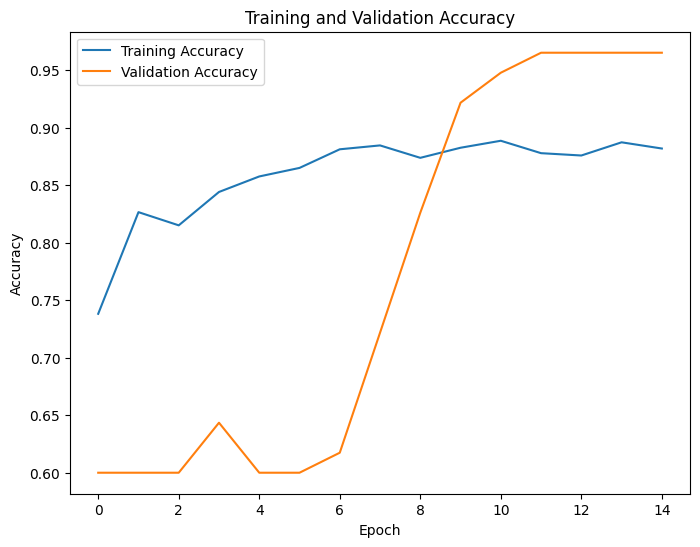

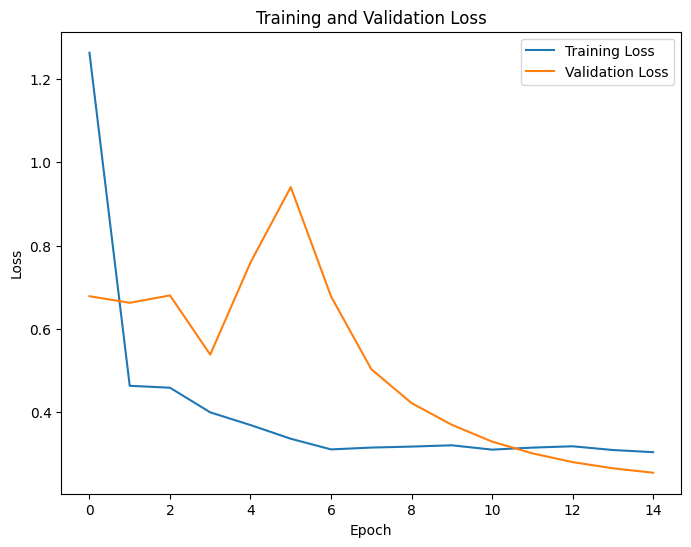

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
# Create a test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=directory,
    x_col='filename',
    y_col='type',
    target_size=img_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False  # Set shuffle to False to maintain order
)




Found 284 validated image filenames belonging to 2 classes.


# Make predictions on the test data

This is the data that we had held out, when trying multiple models and choosing the the best one, we never used this data to improve our models.

we will now use this data to check the accuracy of our model

In [ ]:
# Make predictions on the test data
y_pred_prob = standard_classifier.predict(test_generator)
y_pred = np.round(y_pred_prob).flatten()

# Get true labels from the test data
y_true = test_generator.labels

7/7 [==============================] - 5s 745ms/step


## Classification Report

In [ ]:
# Compute classification report
classification_rep = classification_report(y_true, y_pred)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80       103
           1       0.79      0.97      0.87       120

    accuracy                           0.84       223
   macro avg       0.87      0.83      0.84       223
weighted avg       0.87      0.84      0.84       223



## The Confusion Matrix

In [ ]:
# Compute confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(confusion_mtx)

Confusion Matrix:
[[ 71  32]
 [  3 117]]


In [ ]:
# Compute ROC-AUC score
roc_auc = roc_auc_score(y_true, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9312


## AUC

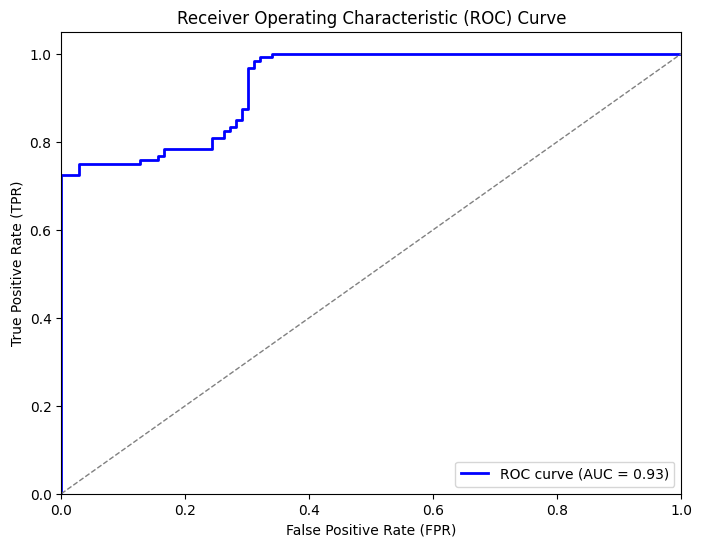

In [ ]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
standard_classifier.save('/content/gdrive/My Drive/trained_model.h5') # Save the model on Google Drive for future predictions

# LOAD THE TRAINED MODEL TO MAKE PREDICTIONS

In [ ]:
from tensorflow.keras.models import load_model
from google.colab import drive
# Mount Google Drive
drive.mount('/content/gdrive') # Uncomment this line to load the model

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from keras.models import Model

# Define the path to your trained model
model_path = '/content/gdrive/My Drive/trained_model.h5'

# Define the input shape corresponding to images
img_size = (700, 460)
channels = 3  #

# Define the dropout rate used during training
dropout_rate = 0.2

n_outputs = 1

# Determine the input shape ofimages
input_shape = img_size + (channels,)

# Set up the model manually with the same architecture as the original/ trained model
# Due to an issue loading the trained model. But we will load the weights.
inputs = Input(shape=input_shape)
x = Conv2D(filters=1*n_filters, kernel_size=5, strides=2, padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = Conv2D(filters=2*n_filters, kernel_size=5, strides=2, padding='same', activation='relu')(x)
x = Conv2D(filters=4*n_filters, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Dropout(dropout_rate)(x)
x = Conv2D(filters=8*n_filters, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Dropout(dropout_rate)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(n_outputs, activation='sigmoid')(x)

# Create the model
model = Model(inputs, outputs)

# Load the trained weights into the new model
model.load_weights(model_path)

In [ ]:
# Make predictions with the model on the test data
predictions = model.predict(test_generator)

9/9 [==============================] - 6s 662ms/step


In [ ]:
# Get the actual labels from the test data generator
# Test_generator returns (batch_x, batch_y) where batch_x is the test image batch and batch_y is the corresponding labels

true_labels = test_generator.labels

# Convert the predicted probabilities to class labels for binary classification
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Sample Predictions

The code below displays some images where both the predicted and actual labels are displayed. 1 stands for malignant and 0 stands for Benign.

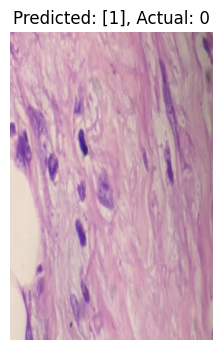

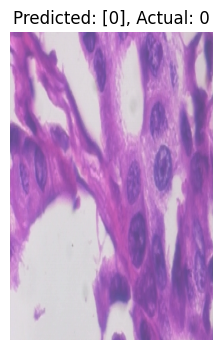

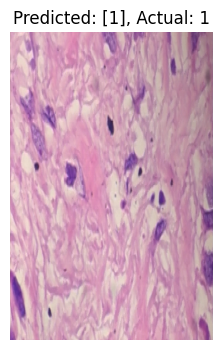

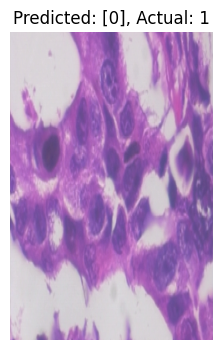

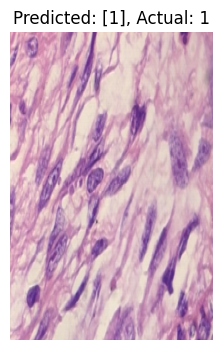

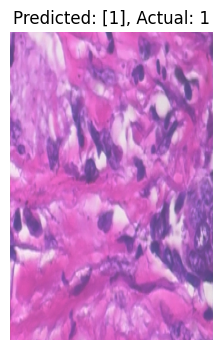

In [ ]:
# Display the images and their predicted and actual labels
num_images_to_display = 6

for i in range(num_images_to_display):
    image = test_generator[i][0][2]  # Get the image from the generator (we can modify the indexing as needed)
    actual_label = true_labels[i]
    predicted_label = predicted_labels[i] if predicted_labels.ndim == 2 else class_labels[i]

    plt.figure(figsize=(6, 4))
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label}, Actual: {actual_label}")
    plt.axis('off')
    plt.show()